# Pix2Pix

In [1]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
import glob
import skimage
import imageio
from tqdm import tqdm_notebook as tqdm

/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/n/.pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class DataLoader():
    """
    supposed
    ./datasets/(dataset_name)/train/source/0.jpg
    ./datasets/(dataset_name)/train/target/0.jpg
    ./datasets/(dataset_name)/test/source/0.jpg
    ./datasets/(dataset_name)/test/target/0.jpg
    ...
    """
    
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        img_source_dir = './datasets/%s/%s/source/*' % (self.dataset_name, data_type)
        img_source_paths = glob.glob(img_source_dir)
        img_source_batch = np.random.choice(img_source_paths, size=batch_size)

        imgs_source, imgs_target = [], []
        for img_source_path in img_source_batch:
            img_source = self.imread(img_source_path)
            img_target = self.imread(img_source_path.replace('source', 'target'))

            img_source = skimage.transform.resize(img_source, self.img_res)
            img_target = skimage.transform.resize(img_target, self.img_res)

            if not is_testing and np.random.random() > 0.5:
                    img_source = np.fliplr(img_source)
                    img_target = np.fliplr(img_target)

            imgs_source.append(img_source)
            imgs_target.append(img_target)

        imgs_source = np.array(imgs_source) / 255
        imgs_target = np.array(imgs_target) / 255

        return imgs_source, imgs_target

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        img_source_dir = './datasets/%s/%s/source/*' % (self.dataset_name, data_type)
        img_source_paths = glob.glob(img_source_dir)[::6]

        self.n_batches = len(img_source_paths) // batch_size

        for i in range(self.n_batches-1):
            img_source_batch = img_source_paths[i*batch_size:(i+1)*batch_size]
            imgs_source, imgs_target = [], []
            for img_source_path in img_source_batch:
                img_source = self.imread(img_source_path)
                img_target = self.imread(img_source_path.replace('source', 'target'))

                img_source = skimage.transform.resize(img_source, self.img_res)
                img_target = skimage.transform.resize(img_target, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_source = np.fliplr(img_source)
                        img_target = np.fliplr(img_target)

                imgs_source.append(img_source)
                imgs_target.append(img_target)

            imgs_source = np.array(imgs_source) / 255
            imgs_target = np.array(imgs_target) / 255

            yield imgs_source, imgs_target


    def imread(self, path):
        return imageio.imread(path, as_gray=False, pilmode='RGB').astype(np.float)

In [3]:
class Pix2Pix():
    def __init__(self, dataset_name='facades'):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = dataset_name
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))

        # Calculate output shape of D (PatchGAN)
        patch = self.img_rows // 2**4
        self.disc_patch = (patch, patch, 1)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        img_source = Input(shape=self.img_shape)
        img_fake = self.generator(img_source)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        validity = self.discriminator([img_fake, img_source])

        self.combined = Model(inputs=img_source, outputs=[validity, img_fake])
        self.combined.compile(
            loss=['mse', 'mae'],
            loss_weights=[1, 100],
            optimizer=optimizer)

    def build_generator(self, gf=64):
        """U-Net Generator"""
        self.gf = gf

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        d0 = Input(shape=self.img_shape)

        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self, df=64):
        self.df = df

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1):
        self.epochs = epochs
        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        self.scores = [] # d_real_loss, d_real_acc, d_fake_loss, d_fake_acc, g_loss, g_acc
        self.val_scores = []

        start_time = datetime.datetime.now()
        print('Train started at', start_time)
        for epoch in tqdm(range(1, epochs + 1)):
            # Training
            score_epoch = []
            for batch_i, (imgs_source, imgs_target) in tqdm(enumerate(self.data_loader.load_batch(batch_size))):
                imgs_fake = self.generator.predict(imgs_source)
                d_score_real_batch = self.discriminator.train_on_batch([imgs_target, imgs_source], valid)
                d_score_fake_batch = self.discriminator.train_on_batch([imgs_fake,   imgs_source], fake)
                g_score_batch = self.combined.train_on_batch(imgs_source, [valid, imgs_target])
                score_epoch.append((*d_score_real_batch, *d_score_fake_batch, *g_score_batch))
                break
            score = tuple(np.mean(score_epoch, axis=0))
            self.scores.append(score)

            # Validating
            val_scores_epoch = []
            for batch_i, (imgs_source, imgs_target) in tqdm(enumerate(self.data_loader.load_batch(batch_size, is_testing=True))):
                imgs_fake = self.generator.predict(imgs_source)
                d_val_score_real_batch = self.discriminator.test_on_batch([imgs_target, imgs_source], valid)
                d_val_score_fake_batch = self.discriminator.test_on_batch([imgs_fake,   imgs_source], fake)
                g_val_score_batch = self.combined.train_on_batch(imgs_source, [valid, imgs_target])
                val_scores_epoch.append((*d_val_score_real_batch, *d_val_score_fake_batch, *g_val_score_batch))
                break
            val_score = tuple(np.mean(val_scores_epoch, axis=0))
            self.val_scores.append(val_score)
                
            elapsed_time = datetime.datetime.now() - start_time
            print("[Epoch: %d/%d][D val_loss: %f, val_acc: %3d%%][G val_loss: %f][time: %s]" % (
                epoch, epochs, (val_score[0] + val_score[2])/2, 100*(val_score[1]+val_score[3]), val_score[4], elapsed_time)
            )
            self._sample_images(epoch)
            self._save_model(epoch)

    def _sample_images(self, epoch, samples=3):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)

        imgs_source, imgs_target= self.data_loader.load_data(batch_size=samples, is_testing=True)
        imgs_fake = self.generator.predict(imgs_source)

        gen_imgs = np.concatenate([imgs_source, imgs_fake, imgs_target])
        gen_imgs = np.clip(gen_imgs, 0, 1)

        titles = ['Source', 'Generated', 'Target']
        r, c = 3, samples
        fig, axs = plt.subplots(r, c)
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[c * i + j])
                axs[i,j].set_title(titles[i])
                axs[i,j].axis('off')
        fig.savefig("images/%s/%d.png" % (self.dataset_name, epoch))
        plt.close()
    
    def _save_model(self, epoch):
        if len(self.val_scores) < 2:
            return
        if min(row[4] for row in self.val_scores[:-1]) > self.val_scores[-1][4]:
            # when g_val_loss is the smallest during a training
            os.makedirs('saved_model', exist_ok=True)
            self.generator.save('saved_model/model-{:03d}.h5'.format(epoch))

In [4]:
pix2pix = Pix2Pix(dataset_name='sakura')
pix2pix.generator.summary()
pix2pix.discriminator.summary()
pix2pix.combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_l

/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [5]:
pix2pix.train(epochs=5, batch_size=1)

Train started at 2018-11-24 19:57:00.304392


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

[Epoch: 1/5][D val_loss: 0.471423, val_acc: 100%][G val_loss: 63.750351][time: 0:00:14.291637]


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/n/.pyenv/versions/3.6.1/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/n/.pyenv/versions/3.6.1/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[Epoch: 2/5][D val_loss: 0.472124, val_acc: 100%][G val_loss: 50.512070][time: 0:00:22.771173]


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

[Epoch: 3/5][D val_loss: 0.671995, val_acc: 100%][G val_loss: 53.808716][time: 0:00:32.421603]


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

[Epoch: 4/5][D val_loss: 0.450100, val_acc: 100%][G val_loss: 64.272095][time: 0:00:40.970298]


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

[Epoch: 5/5][D val_loss: 0.580467, val_acc: 100%][G val_loss: 35.564541][time: 0:00:49.610235]



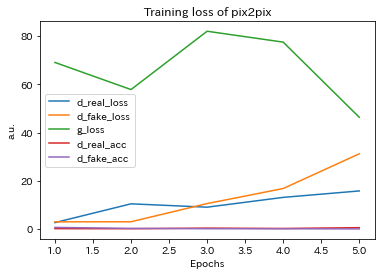

In [6]:
# Plot generator and discriminator accuracy and loss all
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i + 1 for i in range(pix2pix.epochs)]
d_real_loss, d_real_acc, d_fake_loss, d_fake_acc, g_loss, _, _ = zip(*pix2pix.scores)

plt.plot(x, d_real_loss, label="d_real_loss")
plt.plot(x, d_fake_loss, label="d_fake_loss")
plt.plot(x, g_loss,      label="g_loss")
plt.plot(x, d_real_acc,  label="d_real_acc")
plt.plot(x, d_fake_acc,  label="d_fake_acc")
plt.xlabel('Epochs')
plt.ylabel('a.u.')
plt.legend()
plt.title('Training loss of pix2pix')
plt.show()

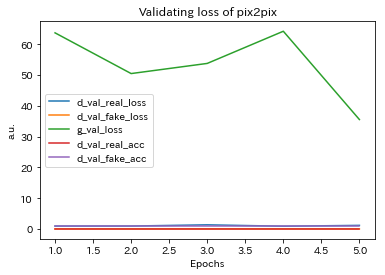

In [9]:
d_real_val_loss, d_real_val_acc, d_fake_val_loss, d_fake_val_acc, g_val_loss, _, _ = zip(*pix2pix.val_scores)

plt.plot(x, d_real_val_loss, label="d_val_real_loss")
plt.plot(x, d_fake_val_loss, label="d_val_fake_loss")
plt.plot(x, g_val_loss,      label="g_val_loss")
plt.plot(x, d_real_val_acc,  label="d_val_real_acc")
plt.plot(x, d_fake_val_acc,  label="d_val_fake_acc")
plt.xlabel('Epochs')
plt.ylabel('a.u.')
plt.legend()
plt.title('Validating loss of pix2pix')
plt.show()